## Install and Includes

In [1]:
! pip install torch nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

In [3]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download([
     "names",
     "stopwords",
     "vader_lexicon",
])

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Load Dataset

WELFake_Dataset input format

- Serial number (starting from 0);
- Title (about the text news heading);
- Text (about the news content);
- Label (0 = fake and 1 = real).

Our final output format

- id
- label	(0 = false, 1 = true)
- sentiment (-1 = negative, 1 = positive)
- BERT embeddings:
    - e0	e1	e2	e3	e4	e5	...	e118	e119	e120	e121	e122	e123	e124	e125	e126	e127


In [4]:
df = pd.read_csv('./WELFake_Dataset.csv') #, nrows=130)
df_filter = df.iloc[0:, 1:4]
df1 = df_filter.sample(8192)
print(df.shape, df1.shape)
df1.head()

(72134, 4) (8192, 3)


,title,text,label
15410,Bangladesh Police Kill Man Suspected of Planni...,"DHAKA, Bangladesh — A Canadian man suspecte...",0
62887,BREAKING! NEW Wikileaks Email: Confidential Au...,The report exposed in an email shared by Wikil...,1
39641,Democratic Senator Franken faces pressure to r...,WASHINGTON (Reuters) - Democrat Al Franken fac...,0
4545,Germany's Schaeuble presses ECB to unwind loos...,WASHINGTON (Reuters) - It would not be a bad i...,0
25009,BREAKING: AP Finds Proof Melania Trump Illegal...,\nIn what may be the last bombshell to drop ...,1


## Enhance with Sentiment

In [5]:
sia = SentimentIntensityAnalyzer()
df1['sentiment'] = df1['text'].apply(lambda x: sia.polarity_scores(str(x))["compound"])
## in case we have to pickup after sentiment - so we can reload
# df1.to_csv("1_with_sentiment.csv", sep=',', encoding='utf-8')

Output format
- title
- text
- label (0 = false, 1 = true)
- sentiment (Vader SentimentAnalyzer - Valence Aware Dictionary and sEntiment Reasoner; specifically attuned to sentiments expressed in social media)
    - Normalize the score to be between -1 and 1 using an alpha that approximates the max expected value (alpha = 15)
    - > The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate. [web](https://github.com/cjhutto/vaderSentiment)

In [6]:
# pickup after a colab timeout / RAM failure
# 36067... 18033... 9016
# out_index=63202
# df1 = pd.read_csv('./1_with_sentiment.csv', skiprows=out_index, nrows=9016,
#                   names=["id","title","text","label","sentiment"])
# df1.head()

## Tokenize and Encode Text

Create features from the text

In [7]:
# Set a random seed
random_seed = 42
random.seed(random_seed)

# Set a random seed for PyTorch (for GPU as well)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = BertModel.from_pretrained("prajjwal1/bert-tiny")
# Future: test with normal bert and PCA?
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")

statements = df1["text"].astype(str).tolist()
print(len(statements[:2][0]), statements[:2])

# Tokenize and encode text
# The function returns a dictionary containing the token IDs and attention masks
encoding = tokenizer.batch_encode_plus(
    statements,                # List of input texts
    padding=True,              # Pad to the maximum sequence length
    truncation=True,           # Truncate to the maximum sequence length if necessary
    return_tensors='pt',       # Return PyTorch tensors
    add_special_tokens=True,   # Add special tokens CLS and SEP
    max_length=512
)

display(encoding[:2])
df1.head()

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

3225 ['DHAKA, Bangladesh  —   A Canadian man suspected of having planned a July attack on a bakery in Dhaka that left 22 people dead was killed in a shootout with the Bangladeshi police on Saturday, officials said. The man, Tamim Ahmed Chowdhury, a    Canadian citizen of Bangladeshi descent, was one of three militants killed in the raid outside Dhaka, the capital, the officials said. The Bangladeshi authorities have said Mr. Chowdhury planned the July 1 assault on the Holey Artisan Bakery, a restaurant popular with expatriates and   Bangladeshis. Some analysts believe Mr. Chowdhury acted as a coordinator for the Islamic State militant group in Bangladesh and northeastern India. The Islamic State has claimed responsibility for several recent attacks in Bangladesh, including the assault on the bakery. The Bangladeshi police, however, identified Mr. Chowdhury as the leader of a new branch of a domestic terrorist group, the Jama’atul Mujahedeen Bangladesh, and the government initially deni

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 16479,  1010,  ...,  3522,  2706,   102],
         [  101,  1996,  3189,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0]])}

,title,text,label,sentiment
15410,Bangladesh Police Kill Man Suspected of Planni...,"DHAKA, Bangladesh — A Canadian man suspecte...",0,-0.9983
62887,BREAKING! NEW Wikileaks Email: Confidential Au...,The report exposed in an email shared by Wikil...,1,-0.5160
39641,Democratic Senator Franken faces pressure to r...,WASHINGTON (Reuters) - Democrat Al Franken fac...,0,-0.1138
4545,Germany's Schaeuble presses ECB to unwind loos...,WASHINGTON (Reuters) - It would not be a bad i...,0,0.9229
25009,BREAKING: AP Finds Proof Melania Trump Illegal...,\nIn what may be the last bombshell to drop ...,1,-0.8350


## Generating Word Embeddings

In [8]:
# Generate embeddings using BERT model
with torch.no_grad():
    outputs = model(encoding["input_ids"], attention_mask=encoding["attention_mask"])
    word_embeddings = outputs.last_hidden_state
    # Result: text_embedding is a tensor of shape [batch_size, hidden_size]
    text_embedding = outputs.last_hidden_state[:, 0, :]

# Output the shape of word embeddings
print(f"Shape of Word Embeddings: {word_embeddings.shape}")
print(f"Shape of Sentence Embeddings: {text_embedding.shape}")
print(text_embedding[0])

Shape of Word Embeddings: torch.Size([8192, 512, 128])
Shape of Sentence Embeddings: torch.Size([8192, 128])
tensor([-8.1629e-02, -1.1041e+00, -3.0189e+00, -6.5340e-01,  1.3357e-02,
        -1.0038e+00, -8.1842e-01,  8.8944e-01,  1.0767e+00,  3.4514e-01,
         4.7467e-01,  3.4723e-01, -9.9338e-02,  1.5904e-01,  9.9424e-01,
        -1.7195e-01, -1.9292e+00,  1.4351e+00, -2.4776e+00,  5.6812e-01,
        -4.8344e-01, -1.3697e-01,  1.6471e+00, -1.2502e-01, -6.8053e-01,
         3.0625e-01,  1.8980e+00,  2.5967e+00,  3.3228e-01, -1.1713e+00,
        -6.3501e-01, -8.3433e-01, -1.0810e+00,  1.1719e+00,  5.0994e-01,
        -7.4455e-02, -1.1464e+00,  1.5082e+00, -4.0121e+00,  3.4502e-01,
        -1.1801e+00,  2.0560e-01,  1.1157e-01, -3.0736e+00, -1.5418e+00,
        -8.7912e-01, -1.0445e+00,  5.5190e-01, -3.5158e-01, -5.1748e-01,
         9.5289e-01,  1.0785e+00, -1.4060e-02,  3.2229e-01, -9.5458e-01,
        -9.4470e-02, -8.1373e-01, -9.1696e-01,  1.8284e+00,  6.6256e-01,
        -4.8935

## Save Embeddings for Model Training

In [9]:
# Convert sentence embeddings to a list of lists
embeddings_list = text_embedding.cpu().numpy().tolist()
# Create a DataFrame from the embeddings
embeddings_df = pd.DataFrame(embeddings_list)
# Concatenate the embeddings DataFrame with the original DataFrame
df_with_embeddings = pd.concat([df1.reset_index(drop=True), embeddings_df], axis=1)
# Rename the columns to e_0 - e_127
embedding_columns = [f'e{i}' for i in range(embeddings_df.shape[1])]
df_with_embeddings.columns = list(df1.columns) + embedding_columns
df_with_embeddings.head()

,title,text,label,sentiment,e0,e1,e2,e3,e4,e5,...,e118,e119,e120,e121,e122,e123,e124,e125,e126,e127
0,Bangladesh Police Kill Man Suspected of Planni...,"DHAKA, Bangladesh — A Canadian man suspecte...",0,-0.9983,-0.081629,-1.104146,-3.018934,-0.653401,0.013357,-1.003832,...,0.550682,1.419585,0.420818,1.026013,0.529172,0.622461,-0.309173,-1.416363,-2.724601,1.189237
1,BREAKING! NEW Wikileaks Email: Confidential Au...,The report exposed in an email shared by Wikil...,1,-0.5160,-1.363308,1.225598,-4.501051,-1.236800,0.351510,0.510695,...,0.211255,0.717100,-0.385437,0.503176,0.525377,0.971105,-0.695956,-1.720053,-1.409213,1.153528
2,Democratic Senator Franken faces pressure to r...,WASHINGTON (Reuters) - Democrat Al Franken fac...,0,-0.1138,-0.222690,0.489413,-4.478621,-0.958149,-0.832303,0.570744,...,-0.886534,0.781421,-0.525199,0.798016,-0.073584,1.277569,-1.604169,-0.002402,-1.793040,2.067286
3,Germany's Schaeuble presses ECB to unwind loos...,WASHINGTON (Reuters) - It would not be a bad i...,0,0.9229,-0.075826,0.598195,-4.326973,-0.849170,-0.052436,-0.255391,...,-0.516717,0.383247,-0.252453,1.195076,0.202860,1.626330,-0.451213,-1.233398,-1.889522,0.980855
4,BREAKING: AP Finds Proof Melania Trump Illegal...,\nIn what may be the last bombshell to drop ...,1,-0.8350,-0.821347,0.311744,-5.563205,-1.026657,0.048256,-0.356120,...,-0.056915,0.592547,-0.581089,-0.058428,0.255925,1.621843,-0.591830,-1.359092,-1.475459,1.595133


In [13]:
# Save dataset to use with our model in matlab
model_input = df_with_embeddings.drop(['title', 'text'], axis=1)
out_index = 0
model_input.to_csv(f"2_model_input_{out_index}.csv", sep=',', encoding='utf-8')

## Visualize Embeddings

In [14]:
if not False:
  embed = df_with_embeddings.loc[:, 'e0':'e127']
  tsne = TSNE(n_components=3, perplexity=15, random_state=42, init='random', learning_rate=200)
  sentence_embeddings_2d = tsne.fit_transform(embed)

In [15]:
tbl = {'true': 1, 'false': 0}
clr = {'1': 'green', '0': 'red' }

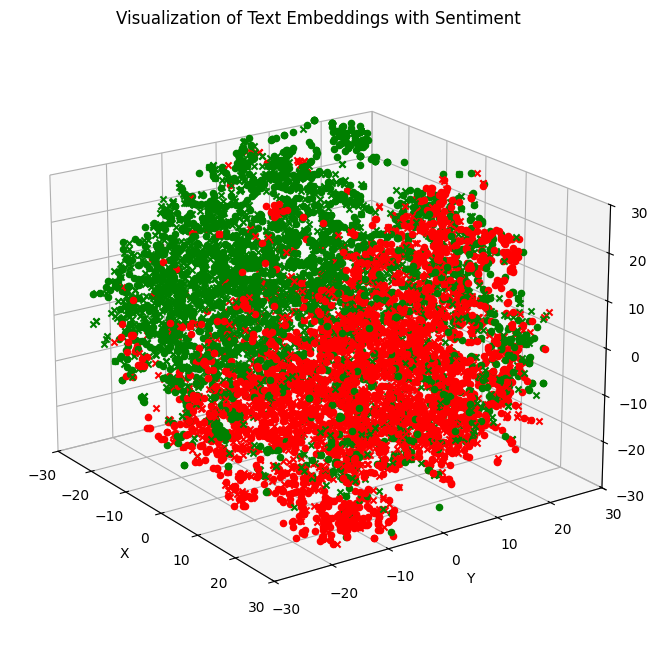

In [22]:
if not False:
  fig = plt.figure(figsize=(15, 8))
  ax = fig.add_subplot(111, projection='3d')

  for i, row in enumerate(sentence_embeddings_2d):
      colour = clr[str(df_with_embeddings.loc[i, 'label'])]
      maker = 'o' if df_with_embeddings.loc[i, 'sentiment'] >= 0 else 'x'
      ax.scatter(row[0], row[1], row[2], c=colour, marker=maker)

  ax.set_title('Visualization of Text Embeddings with Sentiment')
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')

  ax.view_init(elev=20, azim=-35)
  ax.set_xlim([-30, 30])
  ax.set_ylim([-30, 30])
  ax.set_zlim([-30, 30])

  plt.show()